# Graph-to-Hypergraph Spectral Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [236]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [237]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


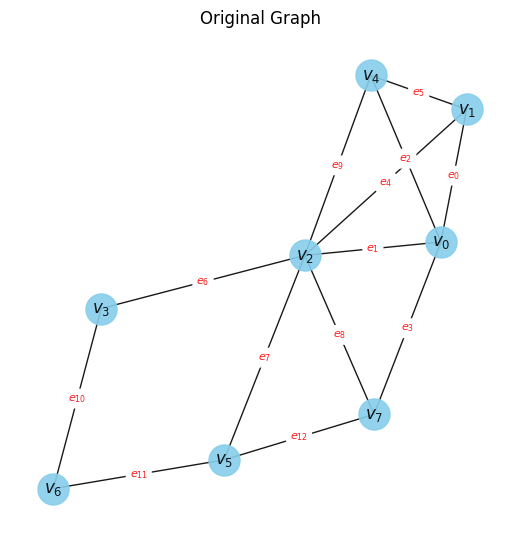

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [238]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example, the spectral lifting was chosen. The lifting algorithm is inspired by the spectral clustering method proposed by Ng, Jordan, and Weiss (2002) [[1]](https://proceedings.neurips.cc/paper/2001/hash/801272ee79cfde7fa5960571fee36b9b-Abstract.html) and maps the clusters identified by the algorithm to hyperedges. The method is based on computing a powerful graph representation leveraging the row-normalized eigenvectors of the normalized laplacian of the adjacency matrix. The current implementation clusters the projected datapoint using KMeans, following the original method. However, any hard of soft clustering method can be used after the implemented projection. The number of clusters can be automatically determined using eigengap heuristics, or provided by setting the n_c parameter of the configuration dictionary.
***
[[1]](https://proceedings.neurips.cc/paper/2001/hash/801272ee79cfde7fa5960571fee36b9b-Abstract.html) Ng, Andrew, Michael Jordan, and Yair Weiss. "On spectral clustering: Analysis and an algorithm." Advances in neural information processing systems 14 (2001).
***


For hypergraphs creating a lifting involves creating the `incidence_hyperedges` matrix.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> simplicial complex -> hypergraph. 

In [239]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2hypergraph/spectral_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}
# [Optional] specify the number of hyperedges/clusters
transform_config["lifting"]["n_c"] = 2


Transform configuration for graph2hypergraph/spectral_lifting:

{'transform_type': 'lifting',
 'transform_name': 'SpectralLifting',
 'n_c': None,
 'cluster_alg': 'KMeans',
 'eps': 1e-09,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:

In [240]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

Processing...
Done!


## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `incidence_hyperedges` matrix so the lifting should make sure to add it to the data.

In [233]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [234]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 